# Information Retrieval Coursework (STW7071CEM)

Task 2:
A subject classification functionality is also required, whether as a standalone software or linked with a search engine. More specifically, the input is a scientific document, and the output is one of zero or more of the following cases: Health, business, and Sport are all areas of study.

## Imports

In [9]:
import os
import string

# Data Handling and Processing
import pandas as pd
import numpy as np
import re
import pandas
# from scipy import interp


# Visualuzation
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

# NLP Packages
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import nltk
from joblib import dump, load


# ML Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier

# Scikit Learn packages
from sklearn.base import clone
from sklearn.preprocessing import label_binarize, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import KFold, cross_validate, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import roc_curve, auc


# Load Datasets

In [12]:
text_df = pd.read_csv('dataset.csv', encoding = "latin1")
text_df.head()

,Category,Sentence
0,Sport,The football match ended in a thrilling 3-2 vi...
1,Sport,The Olympic Games brought together athletes fr...
2,Sport,Tennis superstar Serena Williams secured her s...
3,Health,New research shows that regular exercise can s...
4,Health,The World Health Organization (WHO) has issued...


In [13]:
# Function to read the text files into one dataframe
def readfiles_to_dataframe(directory, category):
    arr = os.listdir(directory)
    strtext = ".txt"
    for textfile in arr:
        if textfile.__contains__(strtext):
            fileObject = open(directory + textfile, "r")
            data = fileObject.read()
            ouvert = pd.read_csv('news_df.csv', index_col="Unnamed: 0")
            ouvert = ouvert.append({"Class": str(category), "Text": data},ignore_index=True)
            ouvert.to_csv('news_df.csv')   


In [14]:
full_df = pd.read_csv('news_df.csv')
print(full_df.shape)
full_df.head()

(130, 3)


,Unnamed: 0,Text,Class
0,0,WorldCom trial starts in New York\n\nThe trial...,business
1,1,Tsunami slows Sri Lanka's growth\n\nSri Lanka'...,business
2,2,Christmas shoppers flock to tills\n\nShops all...,business
3,3,Iraq to invite phone licence bids\n\nIraq is t...,business
4,4,Australia rates at four year high\n\nAustralia...,business


In [15]:
full_df.drop(columns=['Unnamed: 0'], inplace=True)
full_df.head()

,Text,Class
0,WorldCom trial starts in New York\n\nThe trial...,business
1,Tsunami slows Sri Lanka's growth\n\nSri Lanka'...,business
2,Christmas shoppers flock to tills\n\nShops all...,business
3,Iraq to invite phone licence bids\n\nIraq is t...,business
4,Australia rates at four year high\n\nAustralia...,business


## 1. Dataset Exploration

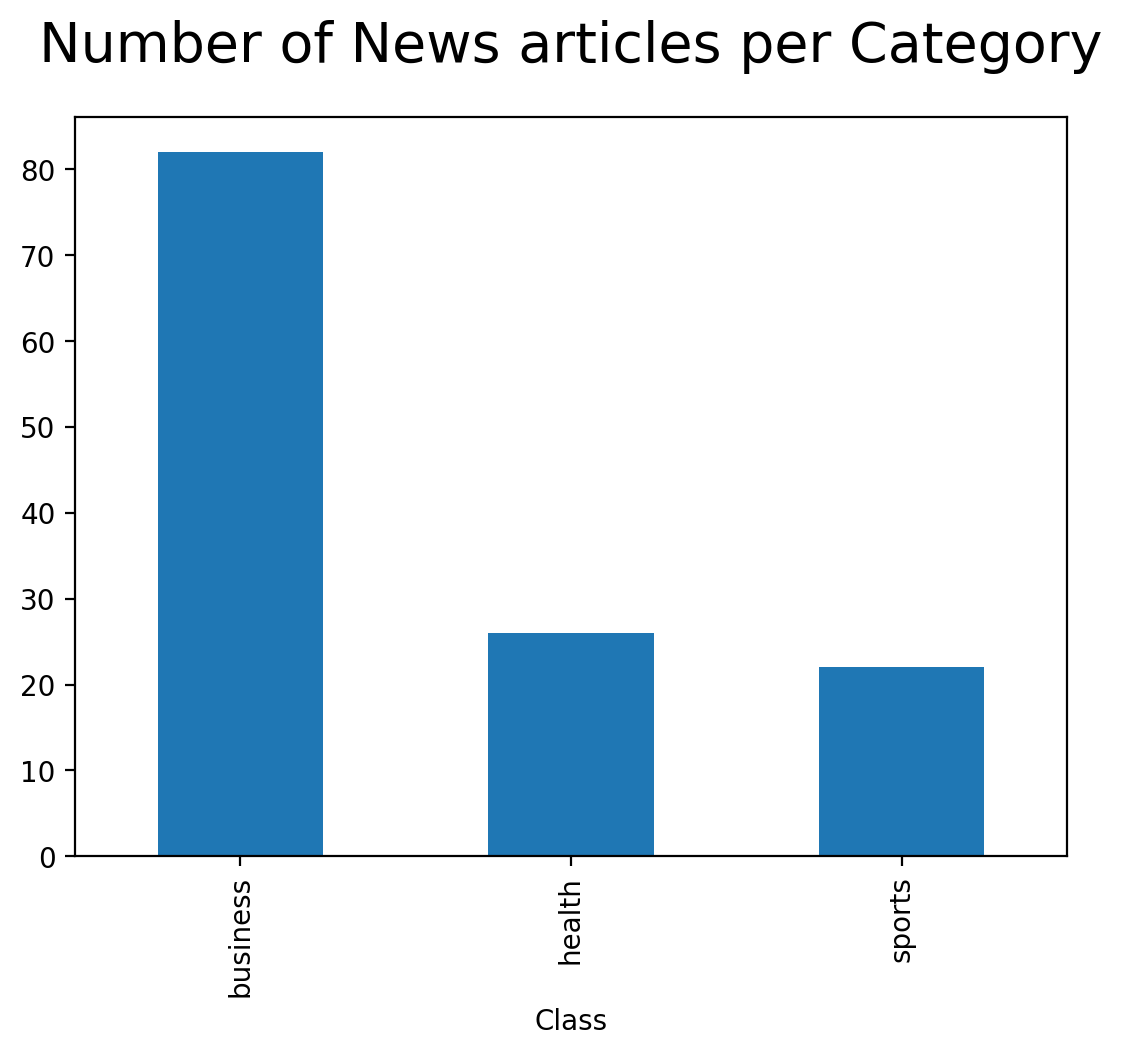

In [16]:
full_df['Class'].value_counts().plot(kind='bar')
plt.title('Number of News articles per Category', size=20, pad=20);

In [17]:
# Check for missing values
full_df.isna().sum()

Text     0
Class    0
dtype: int64

## 2. Text Preprocessing

Here, unwanted parts of the text are removed such as special characters. 

In [18]:
def preprocess(df):
    # Remove special characters
    df['Text2'] = df['Text'].replace('\n',' ')
    df['Text2'] = df['Text2'].replace('\r',' ')
    
    # Remove punctuation signs and lowercase all
    df['Text2'] = df['Text2'].str.lower()
    df['Text2'] = df['Text2'].str.translate(str.maketrans('', '', string.punctuation))
    
    
    # Remove stop words
    stop_words = stopwords.words("english")
    lemmatizer = WordNetLemmatizer()
    
    def fwpt(each):
        tag = pos_tag([each])[0][1][0].upper()
        hash_tag = {"N": wordnet.NOUN,"R": wordnet.ADV, "V": wordnet.VERB,"J": wordnet.ADJ}        
        return hash_tag.get(tag, wordnet.NOUN)

    
    def lematize(text):
        tokens = nltk.word_tokenize(text)
        ax = ""
        for each in tokens:
            if each not in stop_words:
                ax += lemmatizer.lemmatize(each, fwpt(each)) + " "
        return ax
    
    df['Text2'] = df['Text2'].apply(lematize)

In [19]:
preprocess(full_df)

### Demonstration of Preprocessing

**Original:**

In [20]:
full_df.iloc[1]['Text']

'Tsunami slows Sri Lanka\'s growth\n\nSri Lanka\'s president has launched a reconstruction drive worth $3.5bn (£1.8bn) by appealing for peace and national unity.\n\nPresident Kumaratunga said it was now important to find a peaceful solution to years of internal conflict. Meanwhile, the International Monetary Fund (IMF) said damage from the tsunami would cut one percentage point from Sri Lanka\'s economic growth this year. It estimated the wave left physical damage equal to 6.5% of the economy.\n\nSeparately, the International Labour Organisation (ILO) said that at least one million people have lost their livelihoods in Sri Lanka and Indonesia alone. It called for action to create jobs. President Kumaratunga attended a ceremony in the southern town of Hambantota. She was joined by government and opposition politicians, together with Buddhist, Hindu, Muslim and Christian clergy.\n\nPrime Minister Mahinda Rajapakse laid the foundation stone on a new housing project intended to provide 6,0

**Processed:**

In [21]:
full_df.iloc[1]['Text2']

'tsunami slows sri lankas growth sri lankas president launch reconstruction drive worth 35bn £18bn appeal peace national unity president kumaratunga say important find peaceful solution year internal conflict meanwhile international monetary fund imf say damage tsunami would cut one percentage point sri lankas economic growth year estimate wave left physical damage equal 65 economy separately international labour organisation ilo say least one million people lose livelihood sri lanka indonesia alone call action create job president kumaratunga attend ceremony southern town hambantota join government opposition politician together buddhist hindu muslim christian clergy prime minister mahinda rajapakse laid foundation stone new housing project intend provide 6000 home survivor tsunami mr kumaratunga call tragedy start new begin rebuild nation country bless many natural resource make use fully instead squabble fight add norway peace negotiator erik solheim due arrive wednesday try revive 

## 3. Train Test Split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(full_df['Text2'], 
                                                    full_df['Class'], 
                                                    test_size=0.2, 
                                                    random_state=9)

#### Check for acceptable category balance

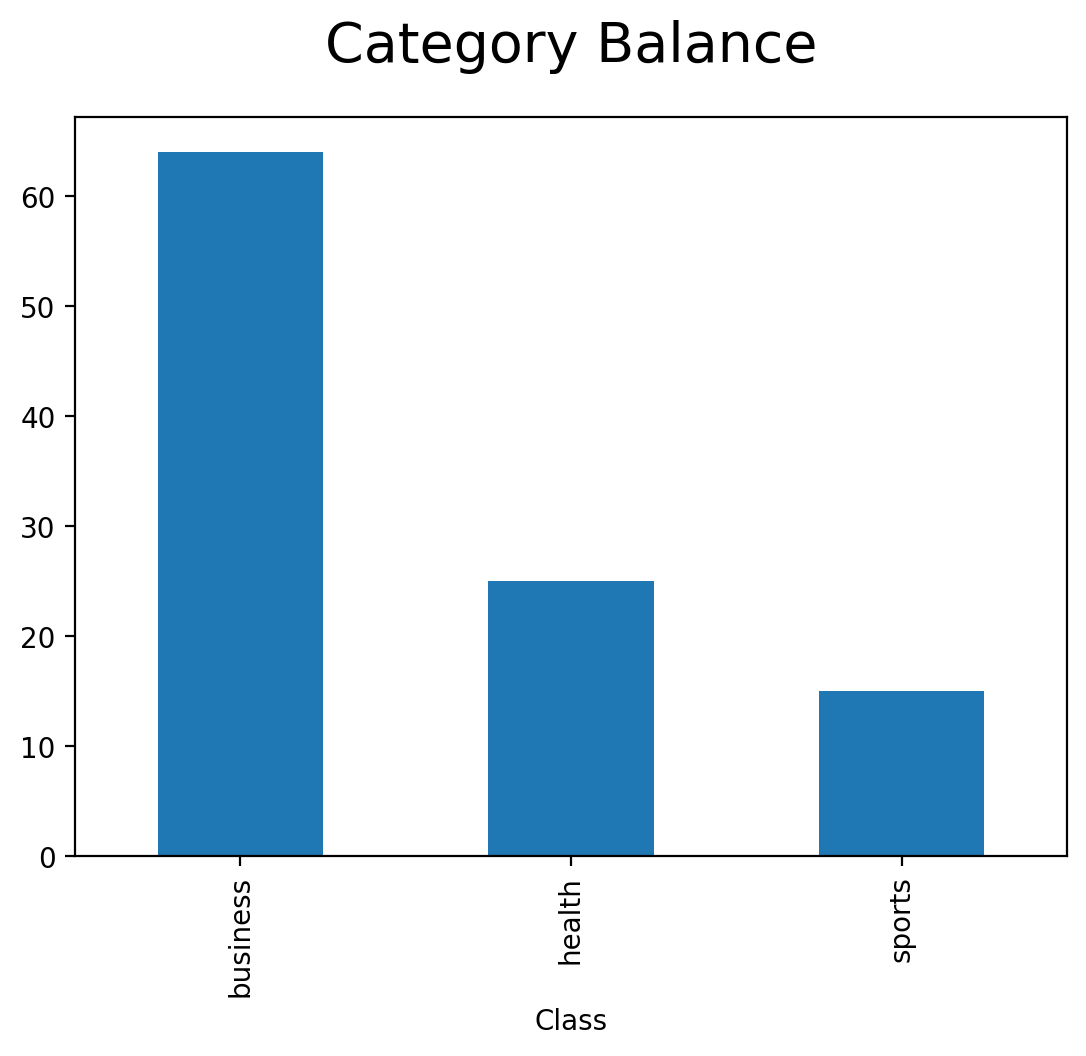

In [23]:
y_train.value_counts().plot(kind='bar')
plt.title('Category Balance', size=20, pad=20);

In [24]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(104,) (26,) (104,) (26,)


## 4.  Vectorize

In [25]:
vector = TfidfVectorizer(stop_words='english', 
                         ngram_range = (1,2),
                         min_df = 3,
                         max_df = 1.,
                         max_features = 10000)

## 5.  Construct Model

In [26]:
def fit_model(model, model_name):
    line = Pipeline([('vectorize', vector), (model_name, model)])
    
    output = cross_validate(line, 
                            X_train, 
                            y_train, 
                            cv = KFold(shuffle = True, 
                                       n_splits = 3,  
                                       random_state = 9),
                            scoring = ('accuracy', 'f1_weighted','precision_weighted','recall_weighted'),           
                            return_train_score=True)
    return output

In [27]:
dectree = fit_model(DecisionTreeClassifier(), 'DTree')
ridge = fit_model(RidgeClassifier(), 'Ridge')
bayes = fit_model(MultinomialNB(), 'NB')

dt = pd.DataFrame.from_dict(dectree)
rc = pd.DataFrame.from_dict(ridge)
bc = pd.DataFrame.from_dict(bayes)

In [28]:
l1 = [bc, rc, dt]
l2 =["NB", "Ridge", "DT"]

for each, tag in zip(l1, l2):
    each['model'] = [tag, tag, tag]

joined_output = pd.concat([bc,rc,dt])

In [29]:
dectree

{'fit_time': array([0.04540014, 0.04131007, 0.04215837]),
 'score_time': array([0.02353525, 0.0122571 , 0.01094747]),
 'test_accuracy': array([1.        , 0.8       , 0.91176471]),
 'train_accuracy': array([1., 1., 1.]),
 'test_f1_weighted': array([1.        , 0.76030178, 0.90537293]),
 'train_f1_weighted': array([1., 1., 1.]),
 'test_precision_weighted': array([1.        , 0.85185185, 0.92156863]),
 'train_precision_weighted': array([1., 1., 1.]),
 'test_recall_weighted': array([1.        , 0.8       , 0.91176471]),
 'train_recall_weighted': array([1., 1., 1.])}

In [30]:
ridge

{'fit_time': array([0.04982305, 0.04199171, 0.04228425]),
 'score_time': array([0.01444411, 0.0151372 , 0.01678658]),
 'test_accuracy': array([0.94285714, 0.94285714, 0.91176471]),
 'train_accuracy': array([1., 1., 1.]),
 'test_f1_weighted': array([0.9414966 , 0.9385034 , 0.90537293]),
 'train_f1_weighted': array([1., 1., 1.]),
 'test_precision_weighted': array([0.94805195, 0.94805195, 0.92156863]),
 'train_precision_weighted': array([1., 1., 1.]),
 'test_recall_weighted': array([0.94285714, 0.94285714, 0.91176471]),
 'train_recall_weighted': array([1., 1., 1.])}

In [31]:
bayes

{'fit_time': array([0.04046321, 0.04103374, 0.04178214]),
 'score_time': array([0.01032495, 0.01205993, 0.01524687]),
 'test_accuracy': array([0.88571429, 0.77142857, 0.85294118]),
 'train_accuracy': array([0.97101449, 0.98550725, 0.95714286]),
 'test_f1_weighted': array([0.87852814, 0.73088435, 0.81902824]),
 'train_f1_weighted': array([0.9707231 , 0.98516241, 0.95413587]),
 'test_precision_weighted': array([0.9047619 , 0.83673469, 0.87829615]),
 'train_precision_weighted': array([0.97227473, 0.98582931, 0.96013289]),
 'test_recall_weighted': array([0.88571429, 0.77142857, 0.85294118]),
 'train_recall_weighted': array([0.97101449, 0.98550725, 0.95714286])}

In [32]:
relevant_measures = list(['test_accuracy','test_precision_weighted', 'test_recall_weighted', 'test_f1_weighted'])

dec_tree_metrics = joined_output.loc[joined_output.model == 'DT'][relevant_measures]
nb_metrics = joined_output.loc[joined_output.model == 'NB'][relevant_measures]
r_metrics = joined_output.loc[joined_output.model == 'Ridge'][relevant_measures]

#### Decision Tree metrics

In [33]:
dec_tree_metrics

,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted
0,1.000000,1.000000,1.000000,1.000000
1,0.800000,0.851852,0.800000,0.760302
2,0.911765,0.921569,0.911765,0.905373


#### Multinomial Naive Bayes metrics

In [34]:
nb_metrics

,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted
0,0.885714,0.904762,0.885714,0.878528
1,0.771429,0.836735,0.771429,0.730884
2,0.852941,0.878296,0.852941,0.819028


#### Ridge Classifier metrics

In [35]:
r_metrics

,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted
0,0.942857,0.948052,0.942857,0.941497
1,0.942857,0.948052,0.942857,0.938503
2,0.911765,0.921569,0.911765,0.905373


#### Average metrics

In [36]:
metrics_ = [dec_tree_metrics, nb_metrics, r_metrics]
names_ = ['Decision Tree', 'Naive Bayes', 'Ridge Classifier']

for scores, namess in zip(metrics_, names_):
    print(f'{namess} Mean Metrics:')
    print(scores.mean())
    print('  ')

Decision Tree Mean Metrics:
test_accuracy              0.903922
test_precision_weighted    0.924473
test_recall_weighted       0.903922
test_f1_weighted           0.888558
dtype: float64
  
Naive Bayes Mean Metrics:
test_accuracy              0.836695
test_precision_weighted    0.873264
test_recall_weighted       0.836695
test_f1_weighted           0.809480
dtype: float64
  
Ridge Classifier Mean Metrics:
test_accuracy              0.932493
test_precision_weighted    0.939224
test_recall_weighted       0.932493
test_f1_weighted           0.928458
dtype: float64
  


### Selection of Model
From the metrics obtained above, we see that **Ridge Classifier** performs best. However, the **Multinomial Naive Bayes classifier** is chosen to create the final model.

This is because it **has the ability to provide probability score** for each prediction it makes, while scoring similarly to the best model.

In [37]:
# Join training and test datasets
X = pd.concat([X_train, 
               X_test])
y = pd.concat([y_train, 
               y_test])

In [38]:
def create_and_fit(clf, x, y):
    best_clf = clf
    pipeline = Pipeline([('vectorize', vector), ('model', best_clf)])
    return pipeline.fit(x, y)

In [39]:
# Create model
CLASSYfier = create_and_fit(MultinomialNB(), X, y)

In [40]:
CLASSYfier.classes_

array(['business', 'health', 'sports'], dtype='<U8')

## FINAL TESTING:

The first sample text used is a tech news article about streaming services and video games. 

The classifier, if appropriate, should classify this as a tech text.

In [44]:
input_text = '''Pelé was simply “The King.” He embraced “the beautiful game” of soccer in his 1958 World Cup debut for Brazil and never really let go.

He won a record three World Cups and was widely regarded as one of his sport’s greatest players. His majestic and galvanizing presence set him among the most recognizable figures in the world.

Pelé died Thursday at 82. He had undergone treatment for colon cancer since 2021.

Pelé was among the game’s most prolific scorers and spent nearly two decades enchanting fans and dazzling opponents. His grace, athleticism and moves on soccer’s highest stage transfixed all. He orchestrated a fast, fluid style of play that revolutionized the sport — a flair that personified Brazilian elegance on the field.

He carried his country to soccer’s heights and became a global ambassador for his sport in a journey that began on the streets of Sao Paulo state, where he would kick a sock stuffed with newspapers or rags.

“Pelé changed everything. He transformed football into art, entertainment,” Neymar, a fellow Brazilian soccer player, said on Instagram. “Football and Brazil elevated their standing thanks to the King! He is gone, but his magic will endure. Pelé is eternal!”

In the conversation about soccer’s greatest player, only the late Diego Maradona, Lionel Messi and Cristiano Ronaldo are mentioned alongside him.

Different sources, counting different sets of games, list Pelé’s goal totals anywhere between 650 (league matches) to 1,281 (all senior matches, some against low-level competition). When Maradona once interviewed Pelé, he playfully asked the Brazilian how he accumulated so many goals.

The player who would be dubbed “The King” was introduced to the world at 17 at the 1958 World Cup in Sweden, the youngest player ever at the tournament.

Pelé was the emblem of his country’s World Cup triumph of 1970 in Mexico. He scored in the final and set up Carlos Alberto with a nonchalant pass for the last goal in a 4-1 victory over Italy.

The image of Pelé in a bright-yellow Brazil jersey, with the No. 10 stamped on the back, remains alive with soccer fans everywhere. As does his trademark goal celebration — a leap with a right fist thrust high above his head.

Pelé’s fame was such that in 1967 factions of a civil war in Nigeria agreed to a brief cease-fire so he could play an exhibition match in the country. He was knighted by Britain’s Queen Elizabeth II in 1997. When Pelé visited Washington to help popularize the game in North America, it was the U.S. president who stuck out his hand first.'''
CLASSYfier.predict_proba([input_text])

array([[0.30728909, 0.14220926, 0.55050165]])

In [45]:
CLASSYfier.predict([input_text])[0]

'sports'

## GUI

In [48]:
import tkinter as tk
from tkinter.scrolledtext import ScrolledText


window = tk.Tk()


window.title("NEWS CLASSIFIER MODEL")
window.minsize(600,400)

text_box = ScrolledText(window)
text_box.grid(column=0, row=1, padx=5, pady=5)

def result(res, pr):
    HEALTH = round(pr[0][0], 3)
    BUSINESS = round(pr[0][1], 3)
    SPORTS = round(pr[0][2], 3)
    
    lines = [f"Health: {HEALTH}", f"Business: {BUSINESS}", f"Sports: {SPORTS}"]
    tk.messagebox.showinfo(message= f"Predicted Category: {str(res).capitalize()}" + "\n\n\n"+"\n".join(lines))

def clickMe():
    classification = tk.StringVar()
    category_,probabilities = classify_text(text_box.get("1.0",tk.END))
    result(category_, probabilities)
    

def classify_text(input_text):
    out = CLASSYfier.predict([input_text])[0]
    probs = CLASSYfier.predict_proba([input_text])
    return out,probs

label = tk.Label(window, text = "Enter Text to Classify")
label.grid(column = 0, row = 0)

btn = tk.Button(window, text="Classify", command=clickMe)
btn.grid(column=0, row=2)
   



window.mainloop()